### Import libraries

In [1]:
import pandas as pd
import os
import shutil
import sys
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow import keras
import tensorflow

from  tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

### Check out the directories

In [2]:
# inserting the parent directory into current path
sys.path.insert(1, '../COVID_19/')

In [3]:
os.listdir('../Dataset/')

['Train', 'Val']

In [4]:
os.listdir('../Dataset/Train/')

['Covid', 'NORMAL']

In [5]:
Train_NORMAL = os.listdir('../Dataset/Train/NORMAL/')
print('Train_NORMAL = ', len(Train_NORMAL))

Train_NORMAL =  166


In [6]:
Train_Covid = os.listdir('../Dataset/Train/Covid/')
print('Train_Covid = ', len(Train_Covid))

Train_Covid =  166


## Quick look to the images 

In [7]:
print('names \n ', Train_NORMAL[0], '\n' ,Train_Covid[0])

names 
  IM-0432-0001.jpeg 
 10.1016-slash-j.anl.2020.04.002-a.png


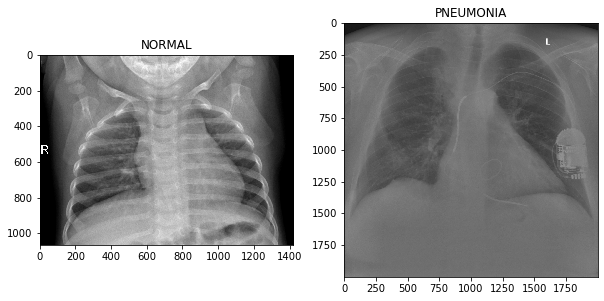

In [8]:
# ref https://www.kaggle.com/feyzazkefe/pneumonia-detection-using-cnn-89-42-acc

img_name = 'NORMAL2-IM-1056-0001.jpeg'
img_normal = load_img('../Dataset/Train/NORMAL/' + img_name)

img_name_1 = 'f6d980a0.jpg'
img_pneumonia = load_img('../Dataset/Train/Covid/' + img_name_1)

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(img_normal)
axs[0].set_title("NORMAL")
axs[1].imshow(img_pneumonia)
axs[1].set_title("PNEUMONIA");

plt.savefig("../Assets/plot_01_assets_1.png")

### Assemble CNN model

In [25]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(224,224,3)))
model.add(Conv2D(64, kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

### Metrics

In [26]:
metr_auc = tensorflow.keras.metrics.AUC(num_thresholds=200, curve='ROC')
TP = tensorflow.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None)
TN = tensorflow.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None)
FP = tensorflow.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None)
FN = tensorflow.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)

Recall_metr = tensorflow.keras.metrics.Recall(thresholds=None, top_k=None, 
                class_id=None, name=None, dtype=None)
# mtr_list = ['accuracy','mse', metr_auc,TP,TN,FP,FN]
mtr_list = ['accuracy', metr_auc]

In [27]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer='adam', 
              metrics=mtr_list)


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 54, 54, 64)       

### Prepare the data

In [28]:
train_datagen = image.ImageDataGenerator(
                featurewise_center=False, samplewise_center=False,
                featurewise_std_normalization=False, samplewise_std_normalization=False,
                zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
                height_shift_range=0.0, brightness_range=None, shear_range=0.2, zoom_range=0.2,
                channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
                horizontal_flip=True, vertical_flip=False, rescale=1./255,
                preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)

In [29]:
val_dataset = image.ImageDataGenerator(rescale=1./255)

In [30]:
train_generator = train_datagen.flow_from_directory(
                    directory='../Dataset/Train/',
                    target_size=(224,224),
                    color_mode="rgb",
                    classes=None,
                    class_mode="binary",
                    batch_size=32,
                    shuffle=True,
                    seed=1234,
                    save_to_dir=None,
                    save_prefix="",
                    save_format="png",
                    follow_links=False,
                    subset=None,
                    interpolation="nearest")

Found 332 images belonging to 2 classes.


In [31]:
train_generator.class_indices

{'Covid': 0, 'NORMAL': 1}

In [32]:
validation_generator = val_dataset.flow_from_directory(
                    directory='../Dataset/val/',
                    target_size=(224,224),
                    color_mode="rgb",
                    classes=None,
                    class_mode="binary",
                    batch_size=32,
                    shuffle=True,
                    seed=1234,
                    save_to_dir=None,
                    save_prefix="",
                    save_format="png",
                    follow_links=False,
                    subset=None,
                    interpolation="nearest")

Found 60 images belonging to 2 classes.


In [33]:
validation_generator.class_indices

{'Covid': 0, 'NORMAL': 1}

In [34]:
# validation_generator = test_dataset.flow_from_directory(
#                         '../COVID_19/Dataset/val/',
#                         target_size =(224,224),
#                         batch_size = 32,
#                         class_mode ='binary')

### Show some images after data augmentation

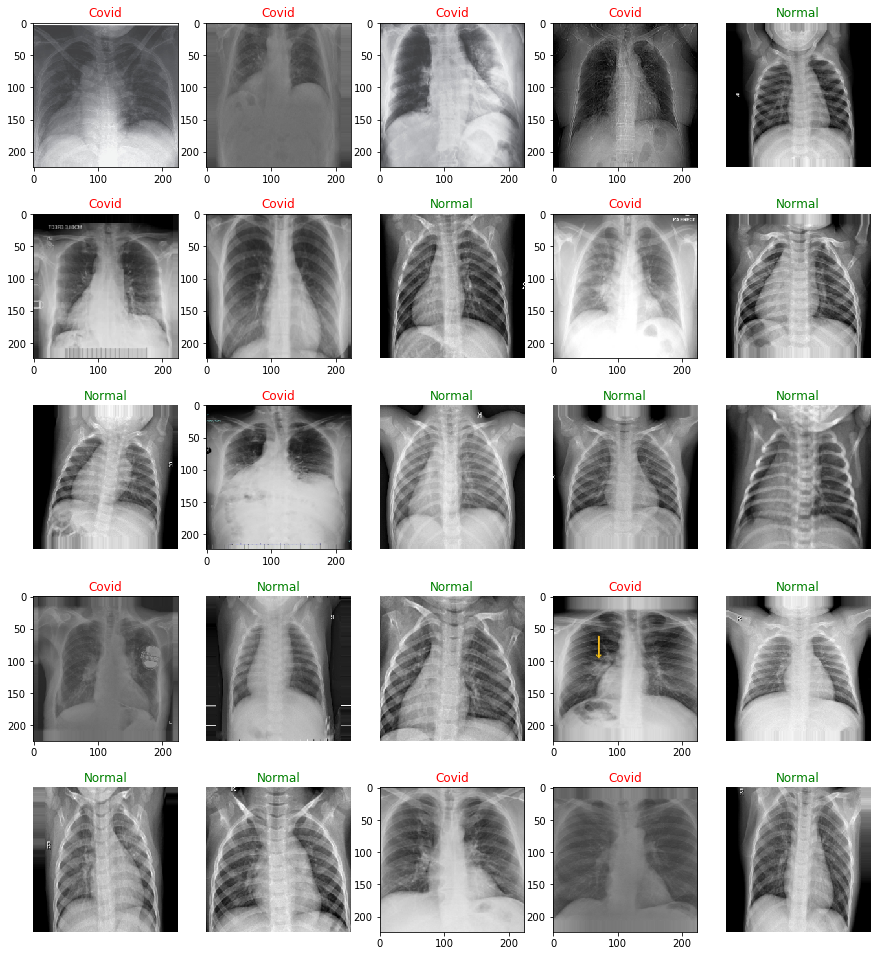

In [35]:
# ref https://www.kaggle.com/feyzazkefe/pneumonia-detection-using-cnn-89-42-acc
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15, 17))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n] ==0:
            tit = plt.title("Covid")
            plt.setp(tit, color='r')

        else:
            tit = plt.title("Normal")
            plt.setp(tit, color='g')
            plt.axis("off")

show_batch(image_batch, label_batch)
plt.savefig("../Assets/plot_01_assets_2.png")

### Train the CNN model

In [36]:
model_history = model.fit_generator(
                generator=train_generator, steps_per_epoch=10, epochs=10, verbose=1, callbacks=None,
                validation_data= validation_generator, validation_steps=2, validation_freq=1,
                class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                shuffle=True, initial_epoch=0
            )

Epoch 1/10
10/10 [==============================] - 16s 2s/step - loss: 1.2403 - accuracy: 0.5533 - auc_1: 0.5258 - val_loss: 0.6722 - val_accuracy: 0.5000 - val_auc_1: 0.9883
Epoch 2/10
10/10 [==============================] - 15s 1s/step - loss: 0.6039 - accuracy: 0.6567 - auc_1: 0.7375 - val_loss: 0.4319 - val_accuracy: 1.0000 - val_auc_1: 1.0000
Epoch 3/10
10/10 [==============================] - 15s 1s/step - loss: 0.4342 - accuracy: 0.8233 - auc_1: 0.8884 - val_loss: 0.1963 - val_accuracy: 0.9667 - val_auc_1: 1.0000
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 0.3521 - accuracy: 0.8567 - auc_1: 0.9333 - val_loss: 0.1815 - val_accuracy: 0.9667 - val_auc_1: 1.0000
Epoch 5/10
10/10 [==============================] - 15s 1s/step - loss: 0.3096 - accuracy: 0.8800 - auc_1: 0.9484 - val_loss: 0.1099 - val_accuracy: 0.9833 - val_auc_1: 1.0000
Epoch 6/10
10/10 [==============================] - 14s 1s/step - loss: 0.2650 - accuracy: 0.9000 - auc_1: 0.9624 - val_

### Plot the History

In [37]:
# list all data in history
print('len(model_history.history.keys()) \n', 
      len(model_history.history.keys()),'\n')
print(model_history.history.keys())

len(model_history.history.keys()) 
 6 

dict_keys(['loss', 'accuracy', 'auc_1', 'val_loss', 'val_accuracy', 'val_auc_1'])


In [38]:
model_history_df = pd.DataFrame(model_history.history)
model_history_df

,loss,accuracy,auc_1,val_loss,val_accuracy,val_auc_1
0,1.240321,0.553333,0.525849,0.672237,0.500000,0.988333
1,0.603870,0.656667,0.737517,0.431917,1.000000,1.000000
2,0.434159,0.823333,0.888439,0.196323,0.966667,1.000000
3,0.352123,0.856667,0.933286,0.181473,0.966667,1.000000
4,0.309578,0.880000,0.948398,0.109905,0.983333,1.000000
5,0.265012,0.900000,0.962422,0.169717,0.983333,1.000000
6,0.224982,0.953333,0.972532,0.052895,0.983333,1.000000
7,0.214918,0.916667,0.973021,0.070280,0.983333,1.000000
8,0.174766,0.936667,0.984777,0.066040,0.983333,1.000000
9,0.187464,0.956667,0.974707,0.049907,0.983333,1.000000


In [39]:
model_history_df.columns

Index(['loss', 'accuracy', 'auc_1', 'val_loss', 'val_accuracy', 'val_auc_1'], dtype='object')

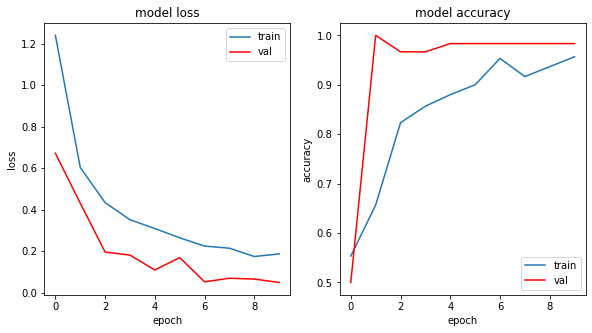

In [40]:
# plt.figure(figsize=(15,17))
# columns = ['loss', 'accuracy', 'mse', 'auc', 'true_positives', 'true_negatives',
#            'false_positives', 'false_negatives']
plt.figure(figsize=(15,17))
columns = ['loss', 'accuracy']
for i,col in enumerate(columns):
    
    plt.subplot(3, 3, i+1)
    
    plt.plot(model_history_df[col])
    plt.plot(model_history_df['val_'+col], color='red')
    plt.title('model '+col)
    plt.ylabel(col)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    
plt.savefig("../Figures/plot_01_1.png")

In [41]:
# model.save("../Codes/Models/model_covid_test.h5")

### Model evaluation

In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [46]:
Covid_img_list = os.listdir('../Dataset/Train/Covid/')
Covid_img_list = [i for i in Covid_img_list if i !='.DS_Store']
# plt.figure(figsize=(20, 10)) 
labels = []
for i, img in enumerate(Covid_img_list):
    path_to_img = '../Dataset/Train/Covid/'+str(img)
    img = load_img(path_to_img, target_size=(224, 224))
    img = img_to_array(img)
    # expand dimensions to match the shape of model input
    img = np.expand_dims(img, axis=0)
    # Generate feature output by predicting on the input image
    feature_output = model.predict(img)
    lab = np.argmax(feature_output, axis=-1)
    labels.append(lab[0])
print(labels)

labels2 = pd.DataFrame(labels,columns=['categ'])
labels2['categ'].value_counts(normalize=False)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0    166
Name: categ, dtype: int64

In [47]:
NORMAL_img_list = os.listdir('../Dataset/Train/NORMAL/')
NORMAL_img_list = [i for i in NORMAL_img_list if i !='.DS_Store']
# plt.figure(figsize=(20, 10)) 
labels = []
for i, img in enumerate(NORMAL_img_list):
    path_to_img = '../Dataset/Train/NORMAL/'+str(img)
    img = load_img(path_to_img, target_size=(224, 224))
    img = img_to_array(img)
    # expand dimensions to match the shape of model input
    img = np.expand_dims(img, axis=0)
    # Generate feature output by predicting on the input image
    feature_output = model.predict(img)
    lab = np.argmax(feature_output, axis=-1)
    labels.append(lab[0])
print(labels)

labels2 = pd.DataFrame(labels,columns=['categ'])
labels2['categ'].value_counts(normalize=False)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0    166
Name: categ, dtype: int64

In [48]:
model.evaluate(train_generator)

11/11 [==============================] - 6s 549ms/step - loss: 0.1697 - accuracy: 0.9307 - auc_1: 0.9851


[0.16971389949321747, 0.9307228922843933, 0.9851030111312866]

In [49]:
model.evaluate(validation_generator)

2/2 [==============================] - 0s 163ms/step - loss: 0.0499 - accuracy: 0.9833 - auc_1: 1.0000


[0.04990679770708084, 0.9833333492279053, 1.0]

### Transfer learning using InceptionV3 models

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input


# create the base pre-trained model
# base_model = InceptionV3(weights='imagenet', include_top=False)
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)
# add a global spatial average pooling layer
x = base_model.output
# x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 1 classes
predictions = Dense(1, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=mtr_list)

Train the model on the new data for a few epochs

In [21]:
model_history = model.fit_generator(
                generator=train_generator, steps_per_epoch=10, epochs=10, verbose=1, callbacks=None,
                validation_data= validation_generator, validation_steps=2, validation_freq=1,
                class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                shuffle=True, initial_epoch=0
            )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
10/10 [==============================] - 8s 821ms/step - loss: 0.0000e+00 - accuracy: 0.5033 - auc: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/10
10/10 [==============================] - 7s 695ms/step - loss: 0.0000e+00 - accuracy: 0.5133 - auc: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/10
10/10 [==============================] - 7s 697ms/step - loss: 0.0000e+00 - accuracy: 0.4967 - auc: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 4/10
10/10 [==============================] - 7s 720ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - auc: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 5/10
10/10 [==============================] - 7s 706ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - auc: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 6/10
10/

In [22]:
# create the base pre-trained model
# base_model = InceptionV3(weights='imagenet', include_top=False)
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)
# add a global spatial average pooling layer
x = base_model.output
# x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 1 classes
predictions = Dense(1, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer='adam', 
              metrics=mtr_list)

In [23]:
model_history = model.fit_generator(
                generator=train_generator, steps_per_epoch=10, epochs=10, verbose=1, callbacks=None,
                validation_data= validation_generator, validation_steps=2, validation_freq=1,
                class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                shuffle=True, initial_epoch=0
            )

Epoch 1/10
10/10 [==============================] - 8s 818ms/step - loss: 7.7771 - accuracy: 0.4900 - auc: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/10
10/10 [==============================] - 7s 724ms/step - loss: 7.3705 - accuracy: 0.5167 - auc: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/10
10/10 [==============================] - 7s 710ms/step - loss: 7.4721 - accuracy: 0.5100 - auc: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 4/10
10/10 [==============================] - 8s 760ms/step - loss: 7.5770 - accuracy: 0.5031 - auc: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 5/10
10/10 [==============================] - 7s 731ms/step - loss: 7.5738 - accuracy: 0.5033 - auc: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 6/10
10/10 [==============================] - 7s 725ms/step - loss: 7.3705 - accuracy: 0.5167 - auc: 0.5000 - val_loss: 7.62

In [50]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_history = model.fit_generator(
                generator=train_generator, steps_per_epoch=10, epochs=10, verbose=1, callbacks=None,
                validation_data= validation_generator, validation_steps=2, validation_freq=1,
                class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                shuffle=True, initial_epoch=0
            )

0 input_2
1 conv2d_98
2 batch_normalization_94
3 activation_94
4 conv2d_99
5 batch_normalization_95
6 activation_95
7 conv2d_100
8 batch_normalization_96
9 activation_96
10 max_pooling2d_7
11 conv2d_101
12 batch_normalization_97
13 activation_97
14 conv2d_102
15 batch_normalization_98
16 activation_98
17 max_pooling2d_8
18 conv2d_106
19 batch_normalization_102
20 activation_102
21 conv2d_104
22 conv2d_107
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_103
29 conv2d_105
30 conv2d_108
31 conv2d_109
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_113
42 batch_normalization_109
43 activation_109
44 conv2d_111
45 conv2d_114
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_110
52 conv2d_112
53 co

In [51]:
Covid_img_list = os.listdir('../Dataset/Train/Covid/')
Covid_img_list = [i for i in Covid_img_list if i !='.DS_Store']
# plt.figure(figsize=(20, 10)) 
labels = []
for i, img in enumerate(Covid_img_list):
    path_to_img = '../Dataset/Train/Covid/'+str(img)
    img = load_img(path_to_img, target_size=(224, 224))
    img = img_to_array(img)
    # expand dimensions to match the shape of model input
    img = np.expand_dims(img, axis=0)
    # Generate feature output by predicting on the input image
    feature_output = model.predict(img)
    lab = np.argmax(feature_output, axis=-1)
    labels.append(lab[0])
print(labels)

labels2 = pd.DataFrame(labels,columns=['categ'])
labels2['categ'].value_counts(normalize=False)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0    166
Name: categ, dtype: int64

In [52]:
NORMAL_img_list = os.listdir('../Dataset/Train/NORMAL/')
NORMAL_img_list = [i for i in NORMAL_img_list if i !='.DS_Store']
# plt.figure(figsize=(20, 10)) 
labels = []
for i, img in enumerate(NORMAL_img_list):
    path_to_img = '../Dataset/Train/NORMAL/'+str(img)
    img = load_img(path_to_img, target_size=(224, 224))
    img = img_to_array(img)
    # expand dimensions to match the shape of model input
    img = np.expand_dims(img, axis=0)
    # Generate feature output by predicting on the input image
    feature_output = model.predict(img)
    lab = np.argmax(feature_output, axis=-1)
    labels.append(lab[0])
print(labels)

labels2 = pd.DataFrame(labels,columns=['categ'])
labels2['categ'].value_counts(normalize=False)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0    166
Name: categ, dtype: int64